# 解析の目的とポアソン回帰
説明変数AとScoreが総授業回数`M`にどれほど影響しているか知りたい。  
- 仮説：<u>アルバイト好きな学生は履修登録に消極的で、出席すべき総授業回数がそもそも少ないのではないか？</u>

授業回数（カウントデータ）のモデリングはポアソン分布を用いるのが適切だろう。

## メカニズムの想像
- 回帰のメカニズムで、`M`が０未満の予測値になるようなことは避けたい
- AとScoreの線型結合を０以上の範囲に変換して、平均授業回数$\lambda$が決まるとする。
- そして$\lambda$から`M`が生成されたと考える。

線型結合をexpで変換すると、0以上の単調増加関数になる。

$$ \lambda[n] \sim exp(b_1 + b_2A[n] + b_3Score[n] $$
$$ M[n] \sim Poisson(\lambda[n]) $$
- $N$：学生の人数
- 推定対象：$b_1, b_2, b_3$

In [1]:
### インポート

# 数値・確率計算
import pandas as pd
import numpy as np
import scipy.stats as stats

# PyMC
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# 描画
import matplotlib.pyplot as plt
import seaborn as sns
# plt.rcParams['font.family'] = 'Meiryo'

# ワーニング表示の抑制
import warnings
warnings.simplefilter('ignore')

In [2]:
### データの読み込み ◆データファイル5.2 data-attendance-2.txtの構成
# PersonID:学生ID、A:バイト好き区分(1:好き), Score:学問の興味の強さ（0~200）
# M:総授業回数（3か月間）, Y:授業出席回数（3か月間）

data = pd.read_csv('./input/data-attendance-2.txt')
print('data.shape: ', data.shape)
display(data.head())

data.shape:  (50, 5)


,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23


In [3]:
### モデルの定義 ◆model5-6.stan

with pm.Model() as model:
    
    ### データ関連定義
    ## coordの定義
    model.add_coord('data', values=data.index, mutable=True)
    model.add_coord('beta', values=[1, 2, 3], mutable=True)
    ## dataの定義
    # 目的変数 M
    M = pm.ConstantData('M', value=data['M'].values, dims='data')
    # 説明変数 A
    A = pm.ConstantData('A', value=data['A'].values, dims='data')
    # 説明変数 Score / 200
    Score = pm.ConstantData('Score', value=data['Score'].values / 200,
                            dims='data')

    ### 事前分布
    b = pm.Uniform('b', lower=-10, upper=10, dims='beta')

    ### lambda 線形予測子の指数変換
    lam = pm.Deterministic('q', pt.exp(b[0] + b[1] * A + b[2] * Score),
                           dims='data')
    
    ### 尤度関数
    obs = pm.Poisson('obs', mu=lam, observed=M, dims='data')

model

  b ~ Uniform(-10, 10)
  q ~ Deterministic(f(b))
obs ~ Poisson(q)

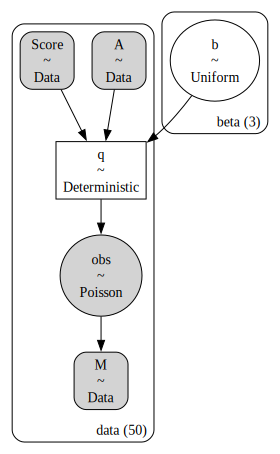

In [4]:
g = pm.model_to_graphviz(model)
display(g)

In [5]:
### 事後分布からのサンプリング 10秒 ◆run-model5-6.R
with model:
    idata = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.8,
                      nuts_sampler='numpyro', random_seed=1234)
    
### r_hat>1.1の確認
# 設定
idata_in = idata         # idata名
threshold = 1.01         # しきい値

# しきい値を超えるR_hatの個数を表示
print((az.rhat(idata_in) > threshold).sum())

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1644.77it/s]


<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    b        int64 8B 0
    q        int64 8B 0


In [6]:
### 推論データの要約統計情報の表示
var_names = ['b', 'q']
pm.summary(idata, hdi_prob=0.95, var_names=var_names, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[1],3.576,0.098,3.397,3.771,0.003,0.002,1116.540,1326.501,1.003
b[2],0.264,0.042,0.183,0.344,0.001,0.001,1924.063,1688.829,1.002
b[3],0.292,0.154,-0.027,0.573,0.005,0.003,1142.256,1436.890,1.003
q[0],39.557,1.960,35.929,43.478,0.056,0.040,1207.595,1785.499,1.002
q[1],57.526,1.971,53.670,61.337,0.045,0.032,1966.042,2285.823,1.001
q[2],42.898,1.219,40.538,45.298,0.024,0.017,2572.371,2268.032,1.001
q[3],52.786,2.211,48.513,57.090,0.053,0.038,1736.723,2217.032,1.002
q[4],58.643,2.350,53.895,63.071,0.059,0.042,1608.634,2092.536,1.001
q[5],43.404,1.286,40.958,46.033,0.025,0.018,2563.093,2431.258,1.001
q[6],42.030,1.238,39.657,44.458,0.028,0.020,1945.963,2429.701,1.001


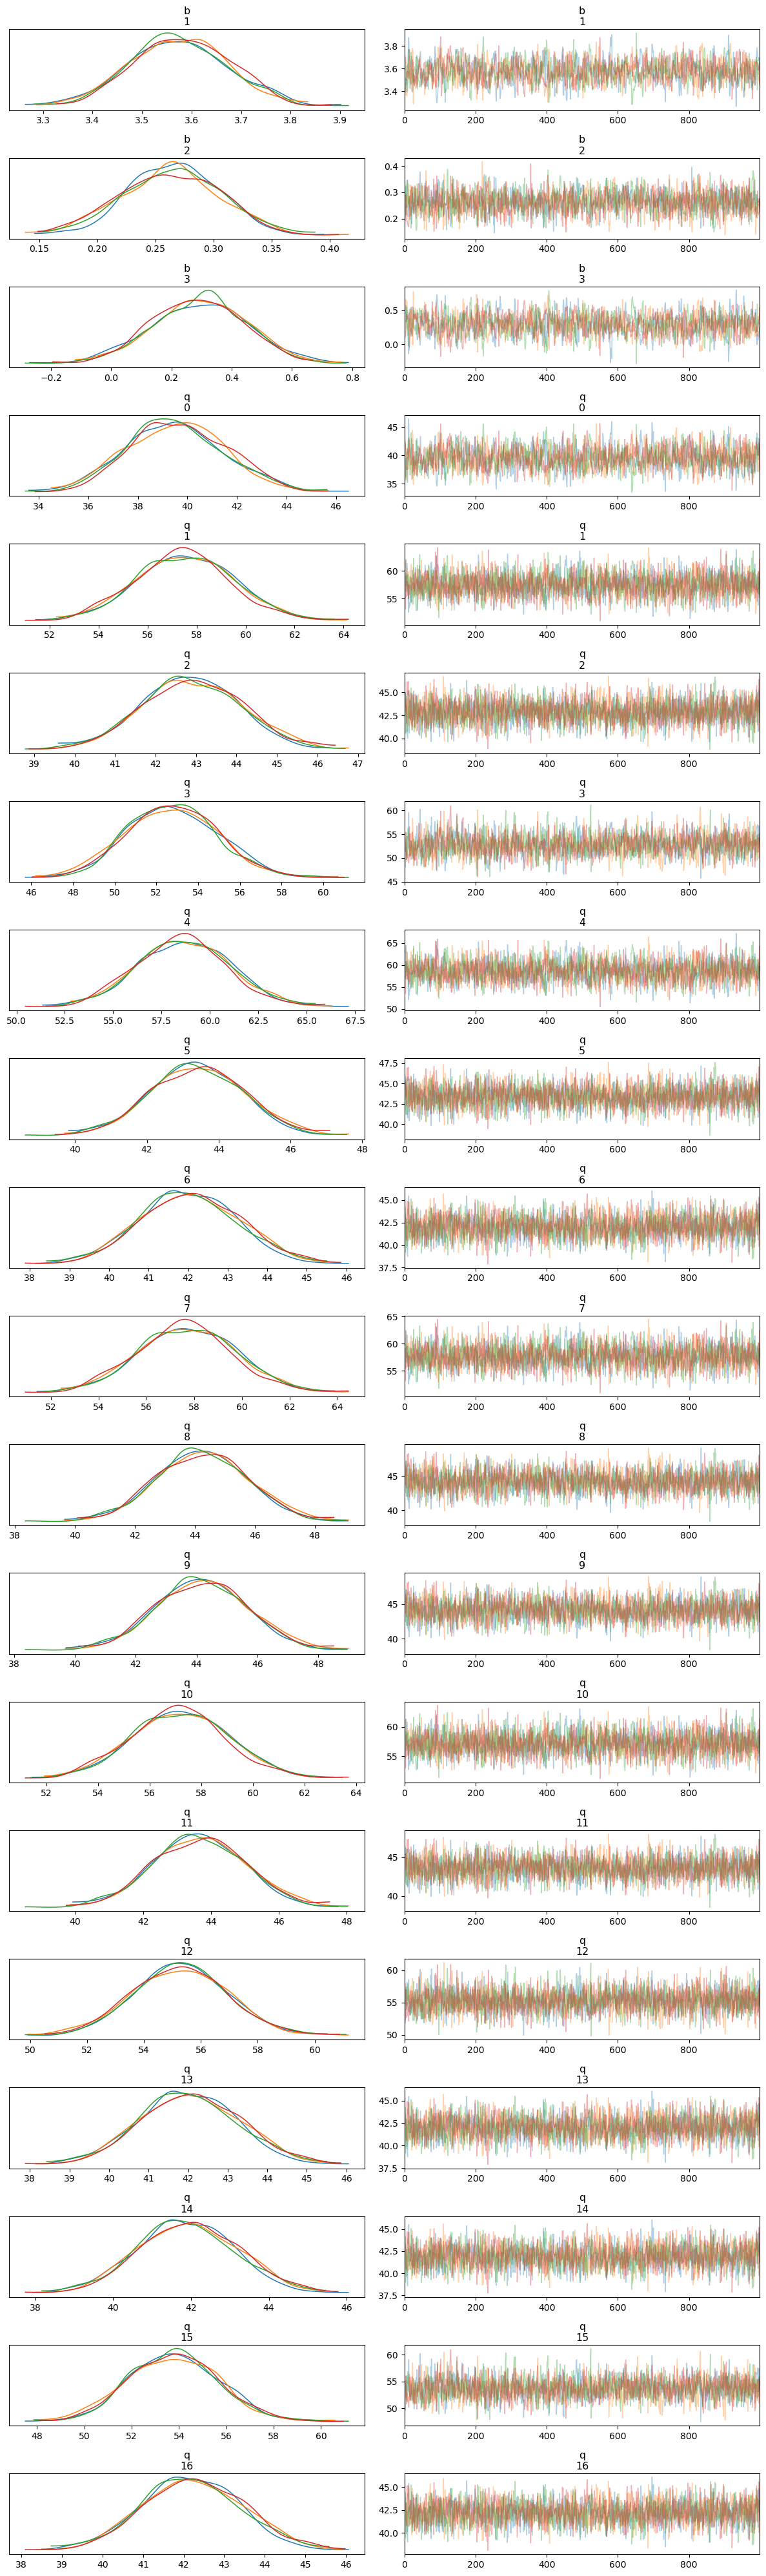

In [7]:
### トレースプロットの表示
pm.plot_trace(idata, compact=False, var_names=var_names)
plt.tight_layout();

In [8]:
### Yの事後予測分布のサンプリング
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=1234))

Sampling: [obs]


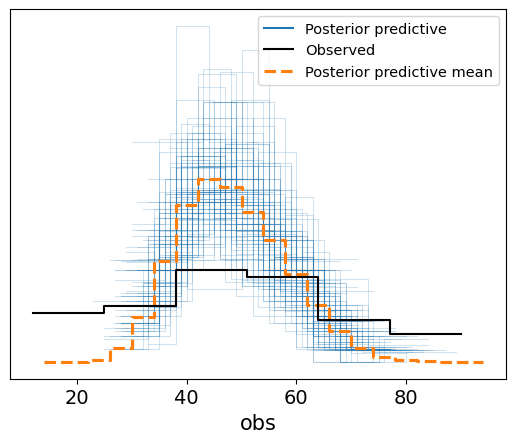

In [9]:
### ppcプロットの描画
pm.plot_ppc(idata, num_pp_samples=100);

In [10]:
### パラメータの要約を確認 ◆テキスト77ページの要約統計量

## 統計量算出関数：mean,sd,2.5%,25%,50%,75%,97.5%点をデータフレーム化する
def make_stats_df(y):
    probs = [2.5, 25, 50, 75, 97.5]
    columns = ['mean', 'sd'] + [str(s) + '%' for s in probs]
    quantiles = pd.DataFrame(np.percentile(y, probs, axis=0).T, index=y.columns)
    tmp_df = pd.concat([y.mean(axis=0), y.std(axis=0), quantiles], axis=1)
    tmp_df.columns=columns
    return tmp_df

## 要約統計量の算出・表示
# 事後分布サンプリングデータidataからパラメータbを取り出してデータフレーム化
param_samples = pd.DataFrame(
    idata.posterior.b.stack(sample=('chain', 'draw')).T.data,
    columns=['b1', 'b2', 'b3'])
# 上記データフレームを統計量算出関数に与えて事後統計量データフレームを作成
params_stats_df = make_stats_df(param_samples)
# 事後統計量データフレームの表示
display(params_stats_df.round(2))

,mean,sd,2.5%,25%,50%,75%,97.5%
b1,3.58,0.10,3.39,3.51,3.57,3.64,3.77
b2,0.26,0.04,0.18,0.24,0.26,0.29,0.34
b3,0.29,0.15,-0.01,0.19,0.30,0.40,0.59


上記様理に基づくと、モデルは以下のようになる。  

$n=1,...N$として  
- $ \lambda[n] = exp(3.58+0.26A[n]+0.29Score[n]/200) $  
- $ M[n] \sim Poisson(\lambda[n]) $

In [11]:
### 授業回数の平均の比を求めてみる ◆テキスト77ページあたりの議論

# 平均λ計算関数の定義
def calc_lambda(a, score, b1, b2, b3):
    return np.exp(b1 + b2 * a + b3 * score / 200)

# パラメータの事後分布サンプルの事後平均を取得
b1_mean = params_stats_df.loc['b1', 'mean']
b2_mean = params_stats_df.loc['b2', 'mean']
b3_mean = params_stats_df.loc['b3', 'mean']

# テキストのScore150と50の平均の比を計算 A=0と仮定
score150 = calc_lambda(0, 150, b1_mean, b2_mean, b3_mean)
score50 = calc_lambda(0, 50, b1_mean, b2_mean, b3_mean)
print(f'Scoreが150と50の授業回数の平均の比: {score150 / score50:.2f}')

# テキストのバイト好き1と好きではない0の平均の比を計算 Score=150と仮定
arbeit1 = calc_lambda(1, 150, b1_mean, b2_mean, b3_mean)
arbeit0 = calc_lambda(0, 150, b1_mean, b2_mean, b3_mean)
print(f'バイト好きと好きではない0の授業回数の平均の比: {arbeit1 / arbeit0:.2f}')

Scoreが150と50の授業回数の平均の比: 1.16
バイト好きと好きではない0の授業回数の平均の比: 1.30
